In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Heuristic Fanction

In [2]:
# Define Heuristics
def heuristic_manhattan(pos, target):
    return abs(pos[0] - target[0]) + abs(pos[1] - target[1])

def heuristic_avoid_enemies(pos, enemies):
    return min([np.linalg.norm(np.array(pos) - np.array(enemy)) for enemy in enemies])

def heuristic_prefer_fast_terrain(pos, terrain):
    return -terrain.get(pos, 0)  # Preference for fast terrain (high positive values)

def heuristic_avoid_high_risk(pos, high_risk_zones):
    return 1 if pos in high_risk_zones else 0


### Adaptive LRTA*

In [3]:
def adaptive_lrta_star(scenario, grid_size, learning_rate=0.1):
    # Dynamically set steps as 2 times the grid size
    max_steps = 2 * grid_size
    probabilities = initial_probabilities.copy()
    prob_history = [probabilities.copy()]
    pos = scenario['start']
    path = [pos]
    deadlocks = 0
    prev_pos = None

    for step in range(max_steps):
        if pos == scenario['target']:
            break

        # Check for deadlock (stuck in the same position)
        if pos == prev_pos:
            deadlocks += 1
        prev_pos = pos

        # Compute heuristic values
        heuristic_values = np.array([
            heuristic_manhattan(pos, scenario['target']),
            heuristic_avoid_enemies(pos, scenario['enemies']),
            heuristic_prefer_fast_terrain(pos, scenario['terrain']),
            heuristic_avoid_high_risk(pos, scenario['high_risk_zones'])
        ])

        # Select heuristic based on adaptive probabilities
        selected_heuristic = np.random.choice(len(probabilities), p=probabilities)
        selected_value = heuristic_values[selected_heuristic]

        # Determine feedback based on distance to target
        distance_to_target = heuristic_manhattan(pos, scenario['target'])
        feedback_strength = max(1, 10 - distance_to_target // (grid_size // 10))
        feedback = -selected_value * feedback_strength  # Stronger feedback as target nears

        # Adaptive movement based on heuristic
        move = (0, 0)
        if selected_heuristic == 0:  # Manhattan Distance
            move = (np.sign(scenario['target'][0] - pos[0]), np.sign(scenario['target'][1] - pos[1]))
        elif selected_heuristic == 1:  # Avoid Enemies
            nearest_enemy = min(scenario['enemies'], key=lambda e: np.linalg.norm(np.array(pos)-np.array(e)))
            move = (np.sign(pos[0] - nearest_enemy[0]), np.sign(pos[1] - nearest_enemy[1]))
        elif selected_heuristic == 2:  # Prefer Fast Terrain
            # Check nearby cells to move towards faster terrain
            nearby_cells = [(pos[0] + dx, pos[1] + dy) for dx in [-1, 1] for dy in [-1, 1]]
            nearby_cells = [cell for cell in nearby_cells if 0 <= cell[0] < grid_size and 0 <= cell[1] < grid_size]
            move = max(nearby_cells, key=lambda c: scenario['terrain'].get(c, 0))
        elif selected_heuristic == 3:  # Avoid High-Risk Zones
            if pos in scenario['high_risk_zones']:
                move = (np.sign(pos[0] - scenario['high_risk_zones'][0][0]), 
                        np.sign(pos[1] - scenario['high_risk_zones'][0][1]))

        pos = (min(max(pos[0] + move[0], 0), grid_size - 1), min(max(pos[1] + move[1], 0), grid_size - 1))
        path.append(pos)

        # Update heuristic probabilities based on feedback
        probabilities[selected_heuristic] += learning_rate * feedback
        probabilities = np.clip(probabilities, 0.01, 1)
        probabilities /= probabilities.sum()  # Normalize
        prob_history.append(probabilities.copy())

    return path, prob_history, deadlocks


### Static LRTA*

In [4]:
# Static LRTA* (fixed heuristic, no learning or adaptation)
def static_lrta_star(scenario, grid_size, steps=50):
    pos = scenario['start']
    path = [pos]
    for step in range(steps):
        if pos == scenario['target']:
            break

        # Always use the Manhattan heuristic
        heuristic_value = heuristic_manhattan(pos, scenario['target'])

        # Move to a new position (simple simulation towards target)
        pos = (min(pos[0] + 1, grid_size - 1), min(pos[1] + 1, grid_size - 1))
        path.append(pos)

    return path


### Stohastic LRTA*

In [5]:
# Stochastic LRTA* (random heuristic choice with probabilistic weights)
def stochastic_lrta_star(scenario, grid_size, learning_rate=0.1, steps=50):
    pos = scenario['start']
    path = [pos]
    
    # Initialize a probability distribution for heuristics
    probabilities = np.array([0.25, 0.25, 0.25, 0.25])  # Assuming 4 heuristics
    for step in range(steps):
        if pos == scenario['target']:
            break

        # Choose a heuristic based on the current probabilities
        selected_heuristic = np.random.choice(4, p=probabilities)
        
        # Evaluate all heuristics (we can use different heuristics based on the selected one)
        heuristic_values = np.array([
            heuristic_manhattan(pos, scenario['target']),
            heuristic_avoid_enemies(pos, scenario['enemies']),
            heuristic_prefer_fast_terrain(pos, scenario['terrain']),
            heuristic_avoid_high_risk(pos, scenario['high_risk_zones'])
        ])

        selected_value = heuristic_values[selected_heuristic]

        # Move to a new position (simple simulation towards target)
        pos = (min(pos[0] + 1, grid_size - 1), min(pos[1] + 1, grid_size - 1))
        path.append(pos)

        # Feedback and adjust probabilities
        feedback = -selected_value  # Example feedback; adjust as needed
        probabilities[selected_heuristic] += learning_rate * feedback
        probabilities = np.clip(probabilities, 0.01, 1)  # Prevent probabilities from reaching 0
        probabilities /= probabilities.sum()  # Normalize
    
    return path


### Evaluation Function

In [6]:
# Define evaluation function
def evaluate_results(results, grid_size):
    metrics = {}
    for method, result in results.items():
        if method == "adaptive":
            path, prob_history, num_deadlocks = result  # Expecting 3 values from adaptive_lrta_star
            total_cost = len(path)  # You can calculate total cost here if applicable
            total_steps = len(prob_history)  # Number of steps (history length)
            final_probs = prob_history[-1] if len(prob_history) > 0 else None
        else:
            path = result  # Static and Stochastic methods, just paths
            total_cost = len(path)  # Use path length as cost
            total_steps = len(path)  # Steps are equal to path length
            final_probs = "N/A"  # No probability history for these methods

        # Evaluate path metrics
        path_length = len(path)
        reached_target = path[-1] == (grid_size - 1, grid_size - 1)

        metrics[method] = {
            'Path Length': path_length,
            'Reached Target': reached_target,
            'Path Cost': total_cost,  # Track total path cost
            'Deadlocks': num_deadlocks,
            'Steps': total_steps,
            'Final Heuristic Probabilities': final_probs  # Final probabilities for adaptive
        }
    return metrics

### Experiment Run & Results (plots)


Running 100 trials on a 10x10 grid...

Evaluation for 10x10 grid over 100 trials:
Adaptive - Avg Path Length: 16.88 (±5.17), Avg Path Cost: 16.88 (±5.17), Avg Deadlocks: 10.99 (±6.18), Avg Steps: 16.88 (±5.17), Reach to Goal Ratio: 43.00% (±49.51%)
Static - Avg Path Length: 10.00 (±0.00), Avg Path Cost: 10.00 (±0.00), Avg Deadlocks: 10.99 (±6.18), Avg Steps: 10.00 (±0.00), Reach to Goal Ratio: 100.00% (±0.00%)
Stochastic - Avg Path Length: 10.00 (±0.00), Avg Path Cost: 10.00 (±0.00), Avg Deadlocks: 10.99 (±6.18), Avg Steps: 10.00 (±0.00), Reach to Goal Ratio: 100.00% (±0.00%)

Running 100 trials on a 50x50 grid...

Evaluation for 50x50 grid over 100 trials:
Adaptive - Avg Path Length: 54.25 (±37.20), Avg Path Cost: 54.25 (±37.20), Avg Deadlocks: 44.80 (±38.42), Avg Steps: 54.25 (±37.20), Reach to Goal Ratio: 71.00% (±45.38%)
Static - Avg Path Length: 50.00 (±0.00), Avg Path Cost: 50.00 (±0.00), Avg Deadlocks: 44.80 (±38.42), Avg Steps: 50.00 (±0.00), Reach to Goal Ratio: 100.00% (±0.0

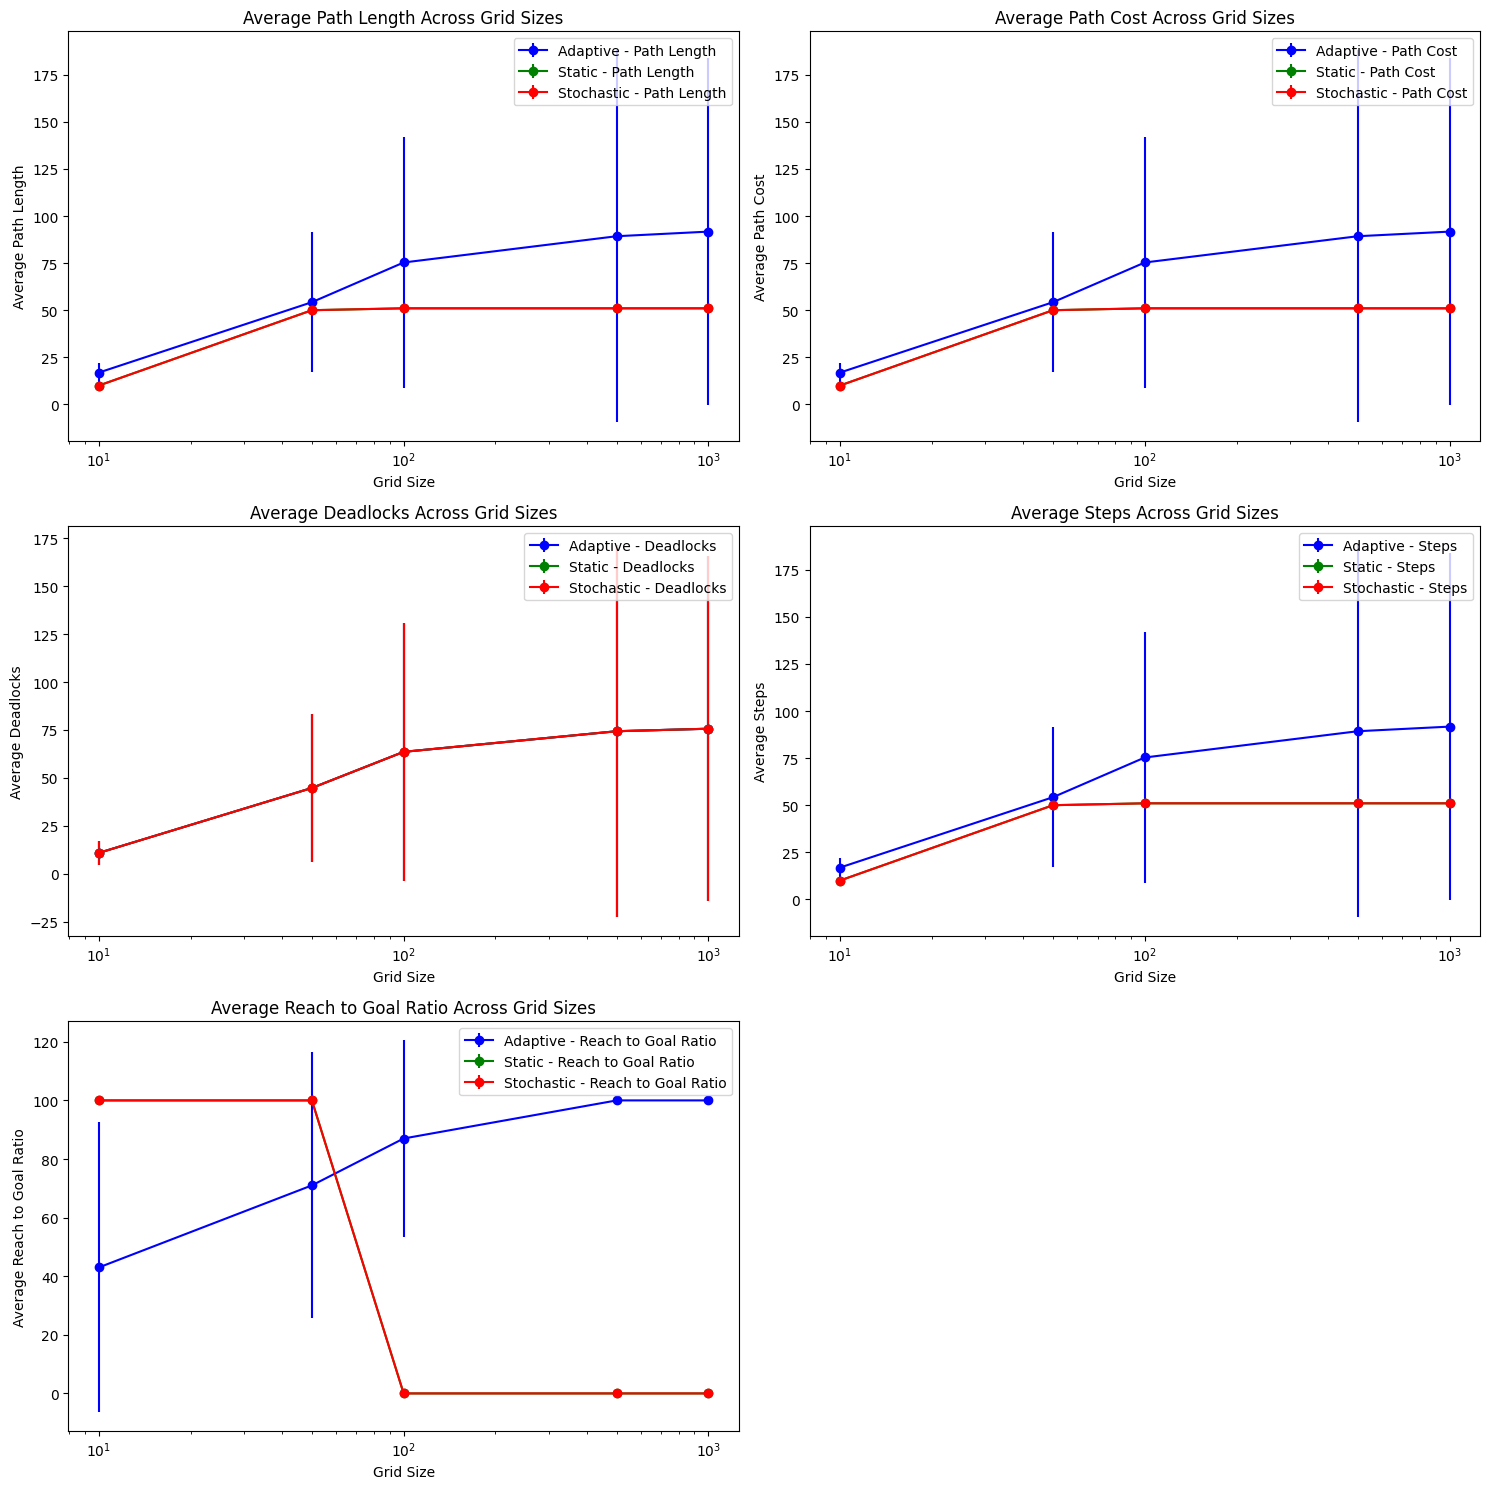

In [7]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)


# Define environment
def create_scenario(grid_size=10):
    return {
        'start': (0, 0),
        'target': (grid_size - 1, grid_size - 1),
        'enemies': [(grid_size // 2, grid_size // 2), (grid_size - 2, grid_size - 2)],
        'terrain': {(x, y): 1 if (x + y) % 2 == 0 else -1 for x in range(grid_size) for y in range(grid_size)},
        'high_risk_zones': [(grid_size // 3, grid_size // 3), (grid_size - grid_size // 4, grid_size - grid_size // 4)]
    }

# Initialize probabilities for each heuristic
initial_probabilities = np.array([0.25, 0.25, 0.25, 0.25])  # Equal probabilities for the 4 heuristics


# Define the number of trials per grid size
num_trials = 100

# Run experiment on different grid sizes
grid_sizes = [10, 50, 100, 500, 1000]
results = {}

# Storage for plotting data
plot_data = {
    'adaptive': {'Path Length': [], 'Path Cost': [], 'Deadlocks': [], 'Steps': [], 'Reach to Goal Ratio': []},
    'static': {'Path Length': [], 'Path Cost': [], 'Deadlocks': [], 'Steps': [], 'Reach to Goal Ratio': []},
    'stochastic': {'Path Length': [], 'Path Cost': [], 'Deadlocks': [], 'Steps': [], 'Reach to Goal Ratio': []},
}

plot_std = {
    'adaptive': {'Path Length': [], 'Path Cost': [], 'Deadlocks': [], 'Steps': [], 'Reach to Goal Ratio': []},
    'static': {'Path Length': [], 'Path Cost': [], 'Deadlocks': [], 'Steps': [], 'Reach to Goal Ratio': []},
    'stochastic': {'Path Length': [], 'Path Cost': [], 'Deadlocks': [], 'Steps': [], 'Reach to Goal Ratio': []},
}

for grid_size in grid_sizes:
    print(f"\nRunning {num_trials} trials on a {grid_size}x{grid_size} grid...")
    
    # Create storage for all metrics across trials
    trial_metrics = {
        'adaptive': {'Path Length': [], 'Path Cost': [], 'Deadlocks': [], 'Steps': [], 'Reach to Goal': []},
        'static': {'Path Length': [], 'Path Cost': [], 'Deadlocks': [], 'Steps': [], 'Reach to Goal': []},
        'stochastic': {'Path Length': [], 'Path Cost': [], 'Deadlocks': [], 'Steps': [], 'Reach to Goal': []}
    }
    
    # Perform trials
    for _ in range(num_trials):
        scenario = create_scenario(grid_size=grid_size)
        
        # Run each method and store results
        trial_result = {
            'adaptive': adaptive_lrta_star(scenario, grid_size),
            'static': static_lrta_star(scenario, grid_size),
            'stochastic': stochastic_lrta_star(scenario, grid_size)
        }
        
        # Evaluate and store metrics for each method
        metrics = evaluate_results(trial_result, grid_size)
        for method in trial_metrics:
            trial_metrics[method]['Path Length'].append(metrics[method]['Path Length'])
            trial_metrics[method]['Path Cost'].append(metrics[method]['Path Cost'])
            trial_metrics[method]['Deadlocks'].append(metrics[method]['Deadlocks'])
            trial_metrics[method]['Steps'].append(metrics[method]['Steps'])
            trial_metrics[method]['Reach to Goal'].append(1 if metrics[method]['Reached Target'] else 0)  # 1 if reached, 0 otherwise
    
    # Calculate average and standard deviation for each metric
    print(f"\nEvaluation for {grid_size}x{grid_size} grid over {num_trials} trials:")
    for method, metrics in trial_metrics.items():
        avg_path_length = np.mean(metrics['Path Length'])
        std_path_length = np.std(metrics['Path Length'])
        avg_path_cost = np.mean(metrics['Path Cost'])
        std_path_cost = np.std(metrics['Path Cost'])
        avg_deadlocks = np.mean(metrics['Deadlocks'])
        std_deadlocks = np.std(metrics['Deadlocks'])
        avg_steps = np.mean(metrics['Steps'])
        std_steps = np.std(metrics['Steps'])
        reach_to_goal_ratio = np.mean(metrics['Reach to Goal']) * 100  # Percentage of trials that reached the goal
        std_reach_to_goal = np.std(metrics['Reach to Goal']) * 100
        
        # Save data for plotting
        plot_data[method]['Path Length'].append(avg_path_length)
        plot_std[method]['Path Length'].append(std_path_length)
        plot_data[method]['Path Cost'].append(avg_path_cost)
        plot_std[method]['Path Cost'].append(std_path_cost)
        plot_data[method]['Deadlocks'].append(avg_deadlocks)
        plot_std[method]['Deadlocks'].append(std_deadlocks)
        plot_data[method]['Steps'].append(avg_steps)
        plot_std[method]['Steps'].append(std_steps)
        plot_data[method]['Reach to Goal Ratio'].append(reach_to_goal_ratio)
        plot_std[method]['Reach to Goal Ratio'].append(std_reach_to_goal)
        
        print(f"{method.capitalize()} - Avg Path Length: {avg_path_length:.2f} (±{std_path_length:.2f}), "
              f"Avg Path Cost: {avg_path_cost:.2f} (±{std_path_cost:.2f}), "
              f"Avg Deadlocks: {avg_deadlocks:.2f} (±{std_deadlocks:.2f}), "
              f"Avg Steps: {avg_steps:.2f} (±{std_steps:.2f}), "
              f"Reach to Goal Ratio: {reach_to_goal_ratio:.2f}% (±{std_reach_to_goal:.2f}%)")

# Plotting the metrics for each method
metrics_to_plot = ['Path Length', 'Path Cost', 'Deadlocks', 'Steps', 'Reach to Goal Ratio']
methods = ['adaptive', 'static', 'stochastic']
colors = {'adaptive': 'blue', 'static': 'green', 'stochastic': 'red'}

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axs[idx]
    for method in methods:
        ax.errorbar(grid_sizes, plot_data[method][metric], yerr=plot_std[method][metric],
                    label=f"{method.capitalize()} - {metric}", fmt='-o', color=colors[method])
    ax.set_title(f"Average {metric} Across Grid Sizes")
    ax.set_xlabel("Grid Size")
    ax.set_ylabel(f"Average {metric}")
    ax.set_xscale('log')
    ax.legend()

# Hide any unused subplots (in case of odd number of metrics)
for j in range(len(metrics_to_plot), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()
